**MUHAMMAD MUAVIA BAI-20S-018**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e41db42cda5961d374d2dd3f011679abe6d957930e7e48a2b2bb244933762720
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import length
from pyspark.sql.types import StringType
from pyspark.sql.functions import size
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics

In [ ]:
pip install wordnet

  Preparing metadata (setup.py) ... done
  Created wheel for wordnet: filename=wordnet-0.0.1b2-py3-none-any.whl size=10500 sha256=89bd6b452375c0d9a9df180fbf9d1f84361110a07951c2b87794506c8195ac72
  Stored in directory: /root/.cache/pip/wheels/c0/a1/e8/4649c8712033dcdbd1e64a0fc75216a5d1769665852c36b4f9
Successfully built wordnet


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

In [ ]:
# Sample data exploration
data_path = "/content/stock_data.csv"
df = spark.read.option("header", "true").csv(data_path, inferSchema=True)

In [ ]:
# Show the first few rows of the DataFrame
df.show(5)

+--------------------+---------+
|                Text|Sentiment|
+--------------------+---------+
|Kickers on my wat...|        1|
|user: AAP MOVIE. ...|        1|
|user I'd be afrai...|        1|
|   MNTA Over 12.00  |        1|
|    OI  Over 21.37  |        1|
+--------------------+---------+
only showing top 5 rows



In [ ]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- Text: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [ ]:
# Display the original column names
original_columns = df.columns
print("Original Column Names:", original_columns)

Original Column Names: ['Text', 'Sentiment']


In [ ]:
# Define new column names
new_column_names = ["content", "sentiment"]

# Assign new names to the columns
df = df.toDF(*new_column_names)

In [ ]:
# Display the new column names
new_columns = df.columns
print("New Column Names:", new_columns)

New Column Names: ['content', 'sentiment']


In [ ]:
# Show the first few rows of the DataFrame
df.show(5)

+--------------------+---------+
|             content|sentiment|
+--------------------+---------+
|Kickers on my wat...|        1|
|user: AAP MOVIE. ...|        1|
|user I'd be afrai...|        1|
|   MNTA Over 12.00  |        1|
|    OI  Over 21.37  |        1|
+--------------------+---------+
only showing top 5 rows



In [ ]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- content: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
# Tokenization, Lemmatization, Stopwords, and Stemming
text_column = "content"

In [ ]:
# Tokenization using RegexTokenizer
tokenizer = RegexTokenizer(inputCol=text_column, outputCol="tokens", pattern="\\W")
df = tokenizer.transform(df)


In [ ]:
# You may need to download the nltk WordNet package (run nltk.download('wordnet') in a separate Python environment)
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
lemmatizer = WordNetLemmatizer()

# Define a UDF for lemmatization
lemmatization_udf = udf(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens], ArrayType(StringType()))

# Apply lemmatization to the tokens column
df = df.withColumn("lemmatized_tokens", lemmatization_udf("tokens"))

In [ ]:
# Stop Words Removal
from pyspark.ml.feature import StopWordsRemover

# Ensure the lemmatized_tokens column is an array of strings
df = df.withColumn("lemmatized_tokens", df["lemmatized_tokens"].cast(ArrayType(StringType())))

# Specify the input and output columns as arrays of strings
remover = StopWordsRemover(inputCol="lemmatized_tokens", outputCol="filtered_tokens")

# Transform the DataFrame
df = remover.transform(df)

In [ ]:
# Stemming using Porter Stemmer
stemmer = PorterStemmer()
stemming_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], StringType())
df = df.withColumn("stemmed_tokens", stemming_udf("filtered_tokens"))

In [ ]:
# Sentiment analysis function
# Replace this with your actual sentiment analysis logic
def analyze_sentiment(tokens):
    return "positive" if "happy" in tokens else "negative"

analyze_sentiment_udf = udf(analyze_sentiment, StringType())
df = df.withColumn("sentiment", analyze_sentiment_udf("filtered_tokens"))

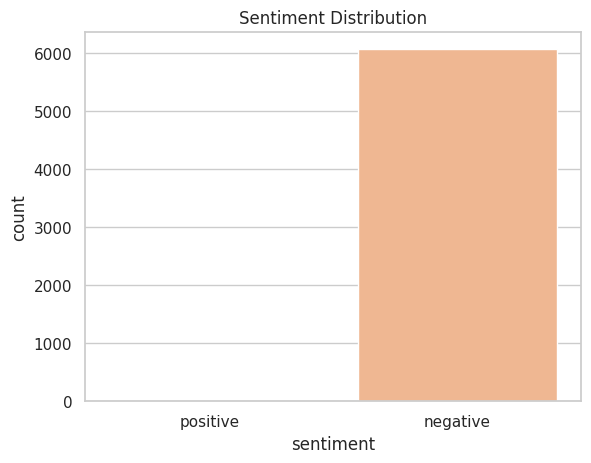

In [ ]:
# Visualization 1: Distribution of sentiments
sentiment_distribution = df.groupBy("sentiment").count().toPandas()
sns.set(style="whitegrid")
sns.barplot(x="sentiment", y="count", data=sentiment_distribution, palette="pastel")
plt.title("Sentiment Distribution")
plt.show()

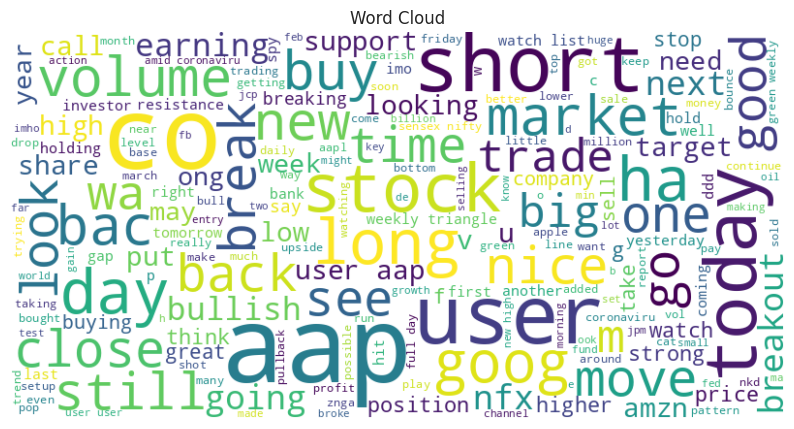

In [ ]:
# Visualization 2: Word cloud
all_words = " ".join(df.select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect())
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

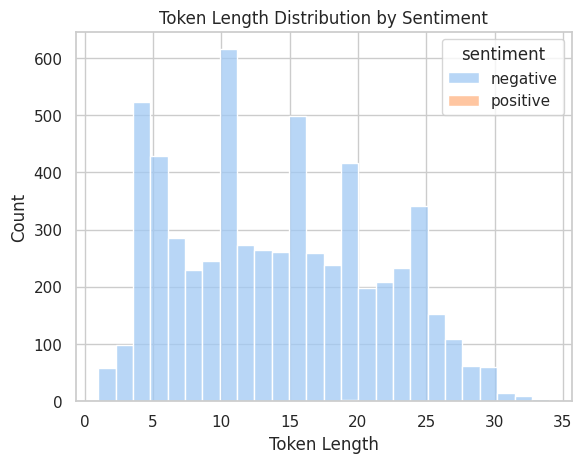

In [ ]:
# Visualization 3: Histogram of token lengths
token_lengths = df.select(col("tokens"), col("sentiment")).rdd.map(lambda x: (len(x[0]), x[1])).toDF(["length", "sentiment"]).toPandas()
sns.histplot(data=token_lengths, x="length", hue="sentiment", multiple="stack", palette="pastel")
plt.title("Token Length Distribution by Sentiment")
plt.xlabel("Token Length")
plt.show()

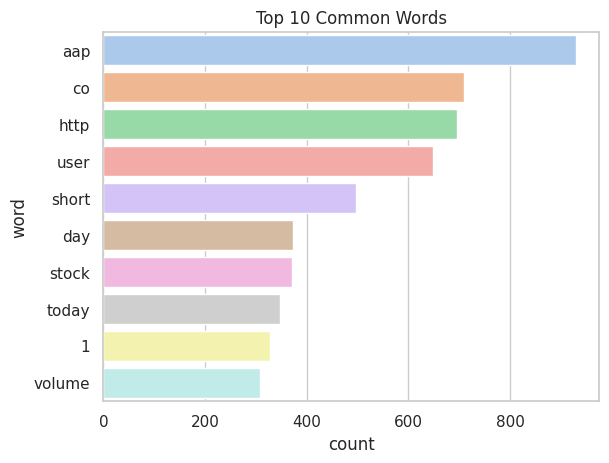

In [ ]:
# Visualization 4: Bar chart of the most common words
from pyspark.sql.functions import explode

# Flatten the lists in the "filtered_tokens" column
df_flat = df.select(explode("filtered_tokens").alias("word"))

# Count occurrences of each word
word_freq = df_flat.groupBy("word").count().orderBy("count", ascending=False).toPandas()

# Visualization using seaborn
sns.barplot(x="count", y="word", data=word_freq.head(10), palette="pastel")
plt.title("Top 10 Common Words")
plt.show()

<ipython-input-27-b376942429d3>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=token_length_sentiment, x="length", y="sentiment", palette="pastel")


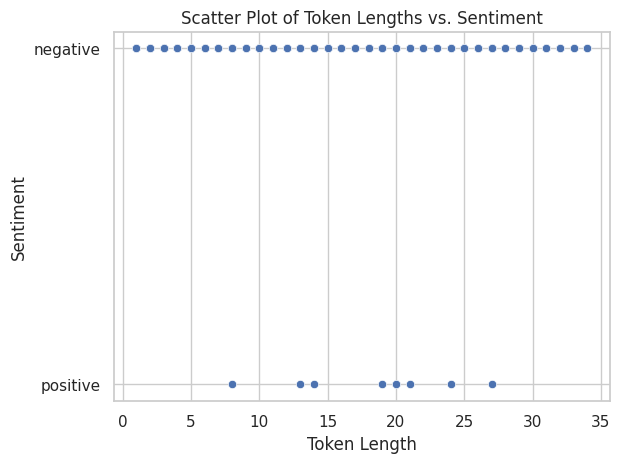

In [ ]:
# Visualization 5: Scatter plot of token lengths vs. sentiment
token_length_sentiment = df.select(col("tokens"), col("sentiment")).rdd.map(lambda x: (len(x[0]), x[1])).toDF(["length", "sentiment"]).toPandas()
sns.scatterplot(data=token_length_sentiment, x="length", y="sentiment", palette="pastel")
plt.title("Scatter Plot of Token Lengths vs. Sentiment")
plt.xlabel("Token Length")
plt.ylabel("Sentiment")
plt.show()

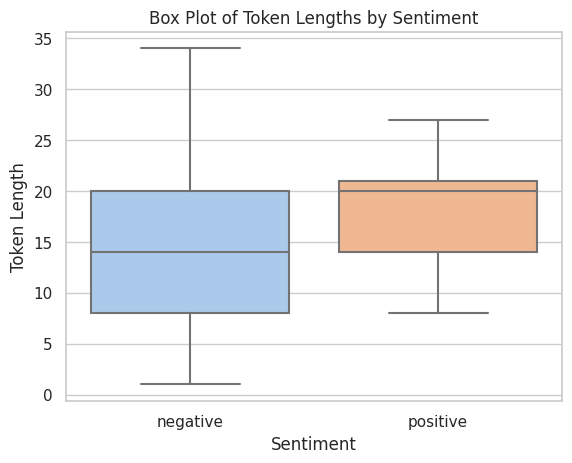

In [ ]:
# Visualization 6: Box plot of token lengths by sentiment
sns.boxplot(data=token_lengths, x="sentiment", y="length", palette="pastel")
plt.title("Box Plot of Token Lengths by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Token Length")
plt.show()

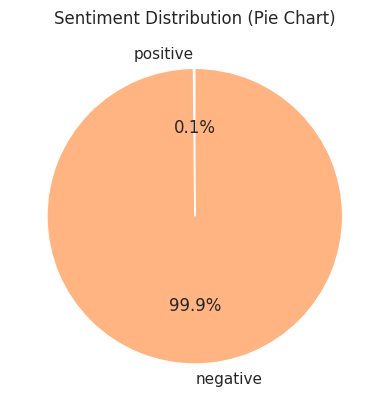

In [ ]:
# Visualization 8: Pie chart of sentiment distribution
sentiment_pie = df.groupBy("sentiment").count().toPandas()
plt.pie(sentiment_pie["count"], labels=sentiment_pie["sentiment"], autopct='%1.1f%%', colors=sns.color_palette("pastel"), startangle=90)
plt.title("Sentiment Distribution (Pie Chart)")
plt.show()